## 1. Data Loading, Processing, and Exploration

In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed
random.seed(42)

# Define dataset path
data_dir = r"D:\Course_25Spring\DEEPL\EuroSAT\2750"
image_size = (64, 64)  # Standard resize size
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

images = []
labels = []

print("Loading images from each class...")
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir, class_name)
    # List all image files in this class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith((".jpg", ".png"))]
    
    for img_file in image_files:
        img_path = os.path.join(class_folder, img_file)
        
        # Open and convert to RGB (to ensure consistent shape)
        with Image.open(img_path).convert("RGB") as img:
            # Convert to a NumPy array
            img_array = np.array(img)
            images.append(img_array)
            labels.append(class_index)

images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")
print(f"Image array shape: {images.shape}")  # e.g., (n_samples, 64, 64, 3)





Loading images from each class...
Total images loaded: 27000
Image array shape: (27000, 64, 64, 3)


Class 'AnnualCrop': 3000 samples
Class 'Forest': 3000 samples
Class 'HerbaceousVegetation': 3000 samples
Class 'Highway': 2500 samples
Class 'Industrial': 2500 samples
Class 'Pasture': 2000 samples
Class 'PermanentCrop': 2500 samples
Class 'Residential': 3000 samples
Class 'River': 2500 samples
Class 'SeaLake': 3000 samples


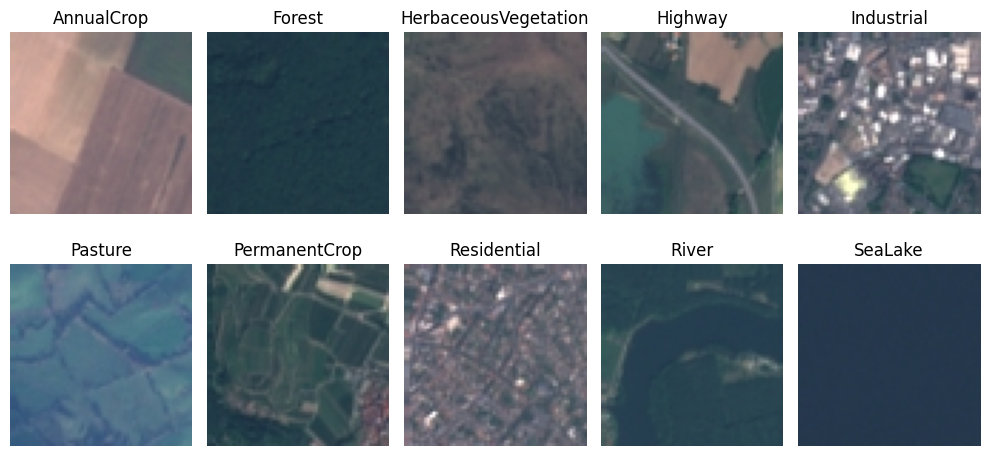

In [3]:
# -------------------------------------------------------
# 2. BASIC EXPLORATORY ANALYSIS
# -------------------------------------------------------
# 2a. Check class distribution
unique_labels, counts = np.unique(labels, return_counts=True)
for lbl, count in zip(unique_labels, counts):
    print(f"Class '{class_names[lbl]}': {count} samples")

# 2b. Show one random image from each class in a 2x5 grid (assuming 10 classes total)
# Adjust rows/cols if you have fewer or more classes
plt.figure(figsize=(10, 5))
for i, c in enumerate(unique_labels):
    plt.subplot(2, 5, i + 1)
    class_indices = np.where(labels == c)[0]
    rand_idx = random.choice(class_indices)
    plt.imshow(images[rand_idx])
    plt.title(class_names[c])
    plt.axis("off")
plt.tight_layout()
plt.show()



In [4]:
# -------------------------------------------------------
# 3. FLATTEN IMAGES INTO 2D MATRIX
# -------------------------------------------------------
# If images are 64x64x3, then each image has 64*64*3 = 12288 features.
n_samples = images.shape[0]
height = images.shape[1]
width = images.shape[2]
channels = images.shape[3] if len(images.shape) == 4 else 1

X = images.reshape(n_samples, height * width * channels)  # shape: (n_samples, p)
y = labels  # just renaming labels to y

print("Feature matrix shape:", X.shape)  # (n_samples, p)



Feature matrix shape: (27000, 12288)


In [5]:
# -------------------------------------------------------
# 4. SPLIT INTO TRAINING (60%) AND TESTING (40%)
#    STRATIFIED BY CLASS
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4, 
    stratify=y, 
    random_state=42
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])




Training set size: 16200
Testing set size: 10800


In [6]:
# -------------------------------------------------------
# 5. CONVERT IMAGES TO GRAYSCALE
# -------------------------------------------------------
# Option A: Convert first, then flatten.
# We'll demonstrate conversion on the original images array (RGB).
# Formula: gray = 0.299*R + 0.587*G + 0.114*B

images_gray = []
for img in images:
    # img shape: (height, width, 3)
    gray_img = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
    # Convert to uint8 if desired
    gray_img = gray_img.astype(np.uint8)
    images_gray.append(gray_img)

images_gray = np.array(images_gray)
print("Grayscale image array shape:", images_gray.shape)  # (n_samples, height, width)



Grayscale image array shape: (27000, 64, 64)


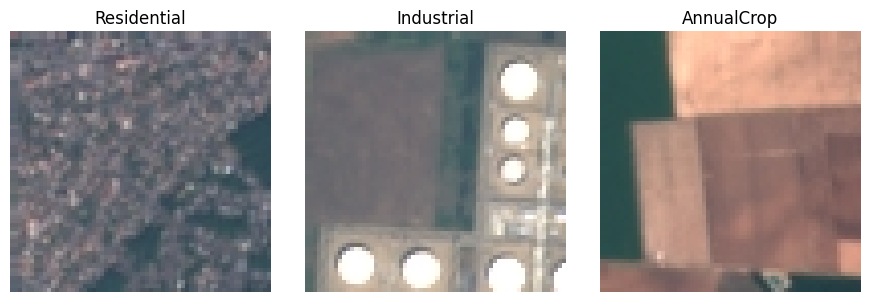

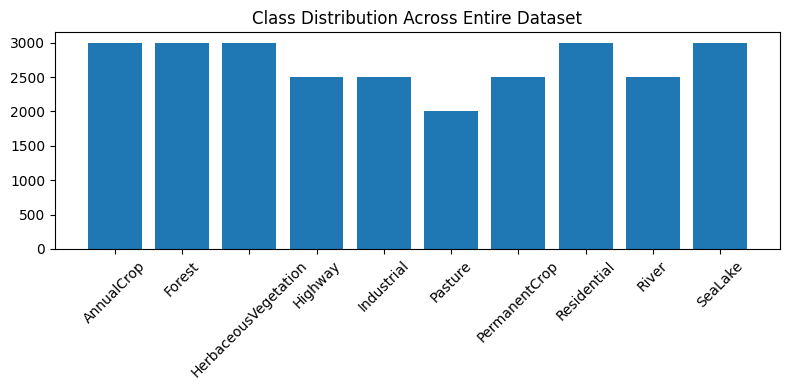

In [ ]:
# Flatten the grayscale images
X_gray = images_gray.reshape(n_samples, height * width)
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    X_gray, y, 
    test_size=0.4, 
    stratify=y, 
    random_state=42
)

# 6. BONUS: DATA AUGMENTATION (Sketch)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


# 7. PLOT RANDOM IMAGES AND A LABEL DISTRIBUTION HISTOGRAM
# -------------------------------------------------------
# 7a. Plot three random images (in RGB)
plt.figure(figsize=(9, 3))
for i in range(3):
    rand_idx = random.randint(0, n_samples - 1)
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[rand_idx])
    plt.title(class_names[y[rand_idx]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# 7b. Histogram of label distribution
plt.figure(figsize=(8, 4))
plt.bar([class_names[i] for i in unique_labels], counts)
plt.title("Class Distribution Across Entire Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Traditional Machine Learning

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Identify the integer labels for the three target classes
target_classes = ["Forest", "Residential", "Industrial"]
target_labels = [class_names.index(cls) for cls in target_classes]

# Create a boolean mask: True if y is in {Forest, Residential, Industrial}
mask = np.isin(y, target_labels)

# Filter the flattened grayscale data and labels
X_3class = X_gray[mask]
y_3class = y[mask]

print("Filtered dataset shape:", X_3class.shape)  # e.g., (num_samples_3class, height*width)
print("Filtered labels shape:", y_3class.shape)

# Split the filtered dataset into train/test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3class, 
    y_3class, 
    test_size=0.4, 
    stratify=y_3class, 
    random_state=42
)

print("3-class Training set size:", X_train_3.shape[0])
print("3-class Testing set size:", X_test_3.shape[0])


Filtered dataset shape: (8500, 4096)
Filtered labels shape: (8500,)
3-class Training set size: 5100
3-class Testing set size: 3400



=== SVM FR ===
Accuracy: 0.9921
Confusion Matrix:
 [[1190   10]
 [   9 1191]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1200
           1       0.99      0.99      0.99      1200

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

AUC: 0.9996

=== SVM RI ===
Accuracy: 0.9186
Confusion Matrix:
 [[1126   74]
 [ 105  895]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      1200
           1       0.92      0.90      0.91      1000

    accuracy                           0.92      2200
   macro avg       0.92      0.92      0.92      2200
weighted avg       0.92      0.92      0.92      2200

AUC: 0.9740

=== SVM FI ===
Accuracy: 0.9995
Confusion Matrix:
 [[1200    0]
 [   1  999]]
Classification Report:
              

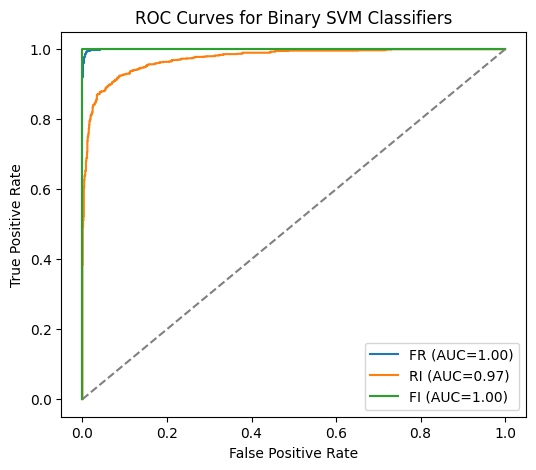

In [9]:
def filter_two_classes(X, y, class_a, class_b):
    """
    Keeps only samples belonging to class_a or class_b.
    Maps class_a -> 0, class_b -> 1 for binary classification.
    """
    mask = (y == class_a) | (y == class_b)
    X_2 = X[mask]
    y_2 = y[mask].copy()
    
    # Map the labels: class_a -> 0, class_b -> 1
    y_2[y_2 == class_a] = 0
    y_2[y_2 == class_b] = 1
    return X_2, y_2

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Identify numeric labels for each class
forest_label = class_names.index("Forest")
residential_label = class_names.index("Residential")
industrial_label = class_names.index("Industrial")

# We'll store models and their evaluation info in dictionaries
svm_models = {}
svm_metrics = {}

# -- 2.2.1 Forest vs Residential --
X_train_FR, y_train_FR = filter_two_classes(X_train_3, y_train_3, forest_label, residential_label)
X_test_FR, y_test_FR = filter_two_classes(X_test_3, y_test_3, forest_label, residential_label)

svm_FR = SVC(kernel='rbf', probability=True, random_state=42)
svm_FR.fit(X_train_FR, y_train_FR)
y_pred_FR = svm_FR.predict(X_test_FR)

acc_FR = accuracy_score(y_test_FR, y_pred_FR)
cm_FR = confusion_matrix(y_test_FR, y_pred_FR)
report_FR = classification_report(y_test_FR, y_pred_FR)

# For ROC, we need predicted probabilities
y_prob_FR = svm_FR.predict_proba(X_test_FR)[:, 1]
fpr_FR, tpr_FR, _ = roc_curve(y_test_FR, y_prob_FR)
auc_FR = roc_auc_score(y_test_FR, y_prob_FR)

svm_models['FR'] = svm_FR
svm_metrics['FR'] = {
    'accuracy': acc_FR,
    'confusion_matrix': cm_FR,
    'classification_report': report_FR,
    'fpr': fpr_FR, 'tpr': tpr_FR, 'auc': auc_FR
}

# -- 2.2.2 Residential vs Industrial --
X_train_RI, y_train_RI = filter_two_classes(X_train_3, y_train_3, residential_label, industrial_label)
X_test_RI, y_test_RI = filter_two_classes(X_test_3, y_test_3, residential_label, industrial_label)

svm_RI = SVC(kernel='rbf', probability=True, random_state=42)
svm_RI.fit(X_train_RI, y_train_RI)
y_pred_RI = svm_RI.predict(X_test_RI)

acc_RI = accuracy_score(y_test_RI, y_pred_RI)
cm_RI = confusion_matrix(y_test_RI, y_pred_RI)
report_RI = classification_report(y_test_RI, y_pred_RI)

y_prob_RI = svm_RI.predict_proba(X_test_RI)[:, 1]
fpr_RI, tpr_RI, _ = roc_curve(y_test_RI, y_prob_RI)
auc_RI = roc_auc_score(y_test_RI, y_prob_RI)

svm_models['RI'] = svm_RI
svm_metrics['RI'] = {
    'accuracy': acc_RI,
    'confusion_matrix': cm_RI,
    'classification_report': report_RI,
    'fpr': fpr_RI, 'tpr': tpr_RI, 'auc': auc_RI
}

# -- 2.2.3 Forest vs Industrial --
X_train_FI, y_train_FI = filter_two_classes(X_train_3, y_train_3, forest_label, industrial_label)
X_test_FI, y_test_FI = filter_two_classes(X_test_3, y_test_3, forest_label, industrial_label)

svm_FI = SVC(kernel='rbf', probability=True, random_state=42)
svm_FI.fit(X_train_FI, y_train_FI)
y_pred_FI = svm_FI.predict(X_test_FI)

acc_FI = accuracy_score(y_test_FI, y_pred_FI)
cm_FI = confusion_matrix(y_test_FI, y_pred_FI)
report_FI = classification_report(y_test_FI, y_pred_FI)

y_prob_FI = svm_FI.predict_proba(X_test_FI)[:, 1]
fpr_FI, tpr_FI, _ = roc_curve(y_test_FI, y_prob_FI)
auc_FI = roc_auc_score(y_test_FI, y_prob_FI)

svm_models['FI'] = svm_FI
svm_metrics['FI'] = {
    'accuracy': acc_FI,
    'confusion_matrix': cm_FI,
    'classification_report': report_FI,
    'fpr': fpr_FI, 'tpr': tpr_FI, 'auc': auc_FI
}

# Print out results for each binary classifier
for pair, metrics in svm_metrics.items():
    print(f"\n=== SVM {pair} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", metrics['classification_report'])
    print(f"AUC: {metrics['auc']:.4f}")

# (Optional) Plot ROC curves for all three
plt.figure(figsize=(6, 5))
for pair, m in svm_metrics.items():
    plt.plot(m['fpr'], m['tpr'], label=f"{pair} (AUC={m['auc']:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Binary SVM Classifiers")
plt.legend()
plt.show()


In [10]:
from collections import Counter

def majority_vote_3classes(x, svm_FR, svm_RI, svm_FI, forest_label, residential_label, industrial_label):
    """
    For a single sample x, get votes from FR, RI, FI classifiers.
    Return the final predicted class label (forest_label, residential_label, or industrial_label).
    """
    # FR: 0 -> forest, 1 -> residential
    vote_FR = svm_FR.predict([x])[0]
    # RI: 0 -> residential, 1 -> industrial
    vote_RI = svm_RI.predict([x])[0]
    # FI: 0 -> forest, 1 -> industrial
    vote_FI = svm_FI.predict([x])[0]
    
    votes = []
    # Convert each binary vote back to the original label
    # FR
    if vote_FR == 0:
        votes.append(forest_label)
    else:
        votes.append(residential_label)
    # RI
    if vote_RI == 0:
        votes.append(residential_label)
    else:
        votes.append(industrial_label)
    # FI
    if vote_FI == 0:
        votes.append(forest_label)
    else:
        votes.append(industrial_label)
    
    # Tally the votes
    most_common = Counter(votes).most_common()
    # most_common is like [(label1, count1), (label2, count2), ...]
    # Return the label with the highest vote count
    return most_common[0][0]

# Apply majority vote to the entire 3-class test set
y_pred_mv = []
for x in X_test_3:
    pred_label = majority_vote_3classes(
        x, svm_models['FR'], svm_models['RI'], svm_models['FI'], 
        forest_label, residential_label, industrial_label
    )
    y_pred_mv.append(pred_label)

y_pred_mv = np.array(y_pred_mv)

# Evaluate
mv_accuracy = accuracy_score(y_test_3, y_pred_mv)
mv_cm = confusion_matrix(y_test_3, y_pred_mv, labels=target_labels)
mv_report = classification_report(y_test_3, y_pred_mv, target_names=target_classes)

print("\n=== Multiclass SVM (Majority Vote) ===")
print(f"Accuracy: {mv_accuracy:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", mv_cm)
print("Classification Report:\n", mv_report)



=== Multiclass SVM (Majority Vote) ===
Accuracy: 0.9418
Confusion Matrix (rows=true, cols=pred):
 [[1190   10    0]
 [   9 1117   74]
 [   0  105  895]]
Classification Report:
               precision    recall  f1-score   support

      Forest       0.99      0.99      0.99      1200
 Residential       0.92      0.90      0.91      1000
  Industrial       0.91      0.93      0.92      1200

    accuracy                           0.94      3400
   macro avg       0.94      0.94      0.94      3400
weighted avg       0.94      0.94      0.94      3400



In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_3, y_train_3)
y_pred_rf = rf.predict(X_test_3)

rf_accuracy = accuracy_score(y_test_3, y_pred_rf)
rf_cm = confusion_matrix(y_test_3, y_pred_rf, labels=target_labels)
rf_report = classification_report(y_test_3, y_pred_rf, target_names=target_classes)

print("\n=== Random Forest (3-class) ===")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", rf_cm)
print("Classification Report:\n", rf_report)



=== Random Forest (3-class) ===
Accuracy: 0.9118
Confusion Matrix (rows=true, cols=pred):
 [[1177   23    0]
 [  15 1030  155]
 [   0  107  893]]
Classification Report:
               precision    recall  f1-score   support

      Forest       0.99      0.98      0.98      1200
 Residential       0.85      0.89      0.87      1000
  Industrial       0.89      0.86      0.87      1200

    accuracy                           0.91      3400
   macro avg       0.91      0.91      0.91      3400
weighted avg       0.91      0.91      0.91      3400



In [12]:
import random

misclassified_idx = np.where(y_pred_rf != y_test_3)[0]
if len(misclassified_idx) > 0:
    # Pick one misclassified example at random
    idx = random.choice(misclassified_idx)
    print(f"Misclassified sample index: {idx}")
    print(f"True label: {class_names[y_test_3[idx]]}, Predicted label: {class_names[y_pred_rf[idx]]}")

    # If you still have the original 2D/3D shape (e.g., images_gray before flattening),
    # you could reshape and visualize it. For grayscale:
    # Remember we sub-selected the data, so the index in X_test_3 might differ from the original array.
    # A simple approach is to keep track of test indices if needed, or do an example-based approach.


Misclassified sample index: 213
True label: Industrial, Predicted label: Residential


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report


3.1 Model 1

In [19]:
# If you haven't already, scale pixel values from [0..255] to [0..1].
# This often helps deep learning models train more effectively.
X_train_gray = X_train_gray / 255.0
X_test_gray = X_test_gray / 255.0

num_classes = 10  # or 3 if you only have three classes
input_dim = X_train_gray.shape[1]  # height*width


In [21]:
# 3.1.1 Model One
model1 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(num_classes, activation='softmax')
])

model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model1.summary()  # See the architecture

history1 = model1.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,  # 20% of training for validation
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
test_loss1, test_acc1 = model1.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model One - Test Accuracy: {test_acc1:.4f}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,970 (160.04 KB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1185 - loss: 2.4390 - val_accuracy: 0.1812 - val_loss: 2.3382
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1683 - loss: 2.3087 - val_accuracy: 0.1420 - val_loss: 2.2996
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1711 - loss: 2.2778 - val_accuracy: 0.1608 - val_loss: 2.2136
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1909 - loss: 2.2503 - val_accuracy: 0.1815 - val_loss: 2.3121
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2039 - loss: 2.2162 - val_accuracy: 0.2806 - val_loss: 2.1249
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2228 - loss: 2.2044 - val_accuracy: 0.2361 - val_loss: 2.1758
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2325 - loss: 2.1618 - val_accuracy: 0.2034 - val_loss: 2.2576
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2419 - loss: 2.1526 - val_accuracy: 0.

In [22]:
# 3.1.2 Model Two
model2 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model2.summary()

history2 = model2.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss2, test_acc2 = model2.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model Two - Test Accuracy: {test_acc2:.4f}")



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,706 (2.01 MB)

 Trainable params: 525,706 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1201 - loss: 2.3794 - val_accuracy: 0.1731 - val_loss: 2.2105
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1523 - loss: 2.2130 - val_accuracy: 0.2120 - val_loss: 2.1398
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1968 - loss: 2.1468 - val_accuracy: 0.2420 - val_loss: 2.0992
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2327 - loss: 2.1032 - val_accuracy: 0.2139 - val_loss: 2.0696
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2664 - loss: 2.0813 - val_accuracy: 0.2235 - val_loss: 2.0398
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2448 - loss: 2.0572 - val_accuracy: 0.2895 - val_loss: 2.0139
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2873 - loss: 2.0032 - val_accuracy: 0.2806 - val_loss: 1.9944
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2697 - loss: 1.9876 - val_accuracy: 0.

In [23]:
# 3.1.3 Model Three
model3 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model3.summary()

history3 = model3.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss3, test_acc3 = model3.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model Three - Test Accuracy: {test_acc3:.4f}")



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,322 (2.03 MB)

 Trainable params: 533,322 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1061 - loss: 2.3651 - val_accuracy: 0.1145 - val_loss: 2.2941
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1086 - loss: 2.2954 - val_accuracy: 0.1145 - val_loss: 2.2933
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1084 - loss: 2.2956 - val_accuracy: 0.1059 - val_loss: 2.2933
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1148 - loss: 2.2941 - val_accuracy: 0.1068 - val_loss: 2.2936
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1107 - loss: 2.2954 - val_accuracy: 0.1068 - val_loss: 2.2936
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1081 - loss: 2.2957 - val_accuracy: 0.1059 - val_loss: 2.2935
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1138 - loss: 2.2965 - val_accuracy: 0.1068 - val_loss: 2.2932
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1112 - loss: 2.2946 - val_accuracy: 0

In [24]:
print(f"Model One Test Accuracy:   {test_acc1:.4f}")
print(f"Model Two Test Accuracy:   {test_acc2:.4f}")
print(f"Model Three Test Accuracy: {test_acc3:.4f}")


Model One Test Accuracy:   0.2765
Model Two Test Accuracy:   0.2690
Model Three Test Accuracy: 0.1111
